# PREDICTING WHETHER A NBA PLAYER WILL LAST MORE THAN 5 YEARS OR NO

Load, explore the data, train and save the best classfier through multiple techniques

In [1]:
import os
import time
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.metrics import recall_score, f1_score, make_scorer, classification_report, confusion_matrix, precision_score, ConfusionMatrixDisplay

import joblib

SEED = 2024
random.seed(SEED)
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2

In [2]:
#loading data
df = pd.read_csv('data/nba_logreg.csv')

# Exploratory data analysis

In [3]:
#data size
len(df)

1340

In [4]:
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1340 non-null   int64  
 2   MIN          1340 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1340 non-null   float64
 13  OREB         1340 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1340 non-null   float64
 17  STL          1340 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

In [6]:
df.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,60.414179,17.624627,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.300299,1.009403,2.025746,3.034478,1.550522,0.618507,0.368582,1.193582,0.620149
std,17.433992,8.307964,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.578479,0.777119,1.360008,2.057774,1.471169,0.409759,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.875000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.700000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.250000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.900000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.400000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


In [7]:
# see duplicated
df.duplicated().sum()

12

In [8]:
df_duplicates = df[df.duplicated()]
print("Doublons détectés :")
df_duplicates

Doublons détectés :


,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
163,Charles Smith,60,8.7,2.9,1.0,2.2,44.4,0.0,0.1,0.0,...,1.3,69.7,0.2,0.9,1.2,1.7,0.6,0.1,0.6,1.0
166,Charles Smith,71,30.4,16.3,6.1,12.4,49.5,0.0,0.0,0.0,...,5.5,72.5,2.4,4.1,6.5,1.5,1.0,1.3,2.1,1.0
169,Charles Smith,34,8.6,3.5,1.4,3.7,39.2,0.4,1.4,31.9,...,0.3,54.5,0.4,0.4,0.8,0.6,0.3,0.2,0.8,1.0
243,Reggie Williams,35,24.5,10.4,4.3,12.2,35.6,0.4,1.7,22.4,...,1.9,72.7,1.6,1.8,3.4,1.7,0.8,0.6,1.8,1.0
339,Ken Johnson,64,12.7,4.1,1.8,3.3,52.8,0.0,0.0,NaN,...,1.3,43.5,1.4,2.4,3.8,0.3,0.2,0.3,0.9,0.0
366,Charles Jones,78,20.1,8.4,3.0,5.8,52.0,0.0,0.1,0.0,...,3.6,64.8,1.8,3.3,5.1,1.6,0.6,0.8,1.8,0.0
369,Charles Jones,29,16.4,3.7,1.3,4.2,31.7,0.7,2.1,31.1,...,0.8,50.0,0.3,1.1,1.4,1.4,0.6,0.2,1.0,0.0
504,Eddie Johnson,74,20.5,9.3,4.0,8.7,45.9,0.0,0.1,9.1,...,2.0,66.4,1.7,2.6,4.4,1.5,0.7,0.2,1.3,1.0
733,Gerald Henderson,43,8.3,2.6,0.9,2.4,35.6,0.1,0.4,21.1,...,1.1,74.5,0.3,0.9,1.3,0.3,0.2,0.2,0.3,1.0
824,Marcus Williams,79,16.6,6.8,2.6,6.7,39.5,0.6,2.1,28.2,...,1.1,84.7,0.4,1.7,2.1,3.3,0.4,0.0,1.8,0.0


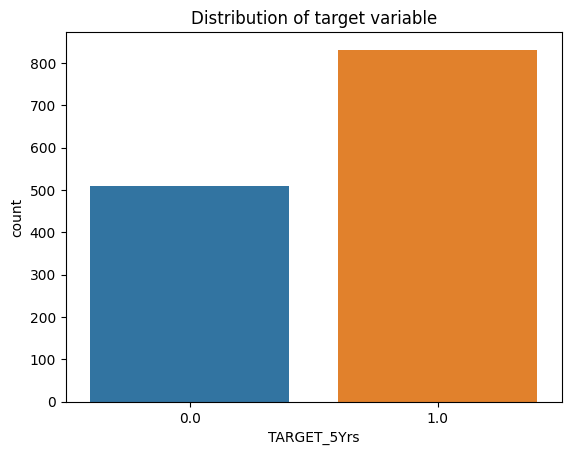

In [9]:
# let's look at the target variable distribution
sns.countplot(x='TARGET_5Yrs', data=df)
plt.title('Distribution of target variable')
plt.show()

We can notice that there is an imbalance between the two classes. There are clearly more 1 than 0. This imballance can affect the performance of the classfication models. 
In this case, it is import to choose the suited metrics as Recall for the 0's class to correctly evaluate the capacity of the model to identify players who don't last more than 5 years.

In [10]:
#features
categorical_features = df.select_dtypes(include=['object']).columns #Name
numerical_features = df.select_dtypes(include=[np.number]).columns
print(categorical_features)

Index(['Name'], dtype='object')


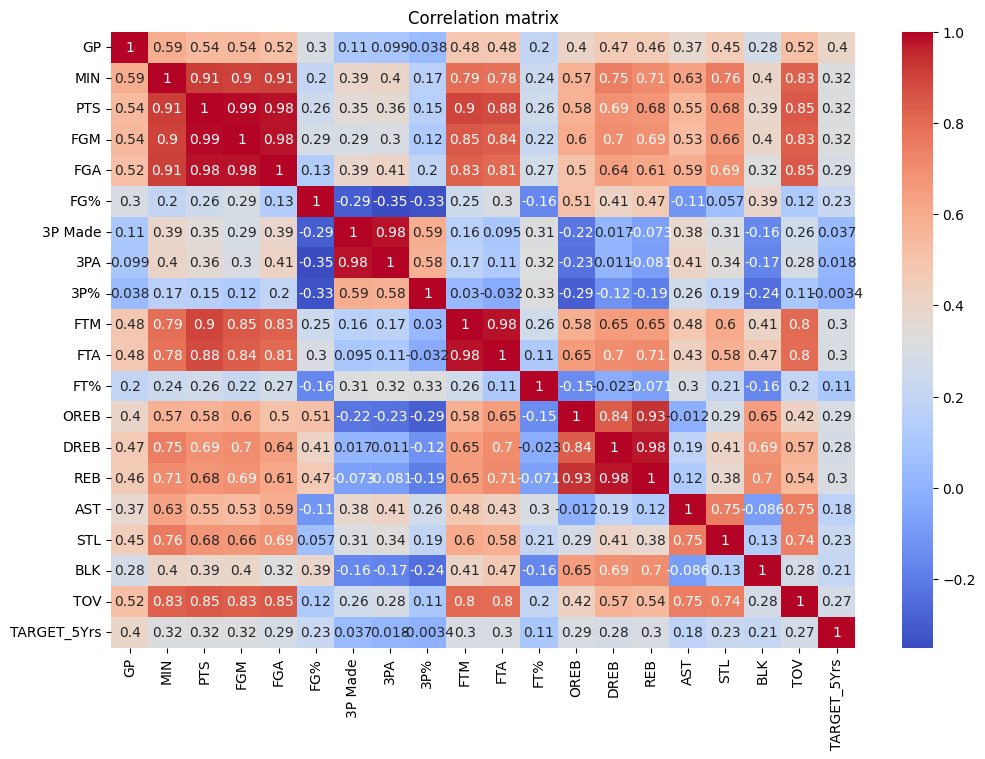

In [11]:
# let's look at correlations between characterics and the target variable
df_n = df.drop(categorical_features[0], axis=1)
corr_mat = df_n.corr()

# filter
# threeshold = 0.6
# corr_mat[corr_mat.abs() < threeshold] = 0
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()


Certain characteristics exhibit very high correlations among them. For example, PTS (points), FGM (field goals made), FGA (field goals attempted), and MIN (minutes) have very high correlations, close to 1. This suggests that these variables are strongly related, likely because players who play more minutes have more opportunities to score points and attempt shots.

The target variable TARGET_5Yrs shows moderate positive correlations with several characteristics:\
    * GP (games played): 0.4\
    * MIN (minutes): 0.32 \
    * PTS (points): 0.32 \
    * FGM (field goals made): 0.32\
    * FTA (free throws attempted): 0.29\
    * OREB (offensive rebounds): 0.29\
    *  REB (total rebounds): 0.28\
    * DREB (defensive rebounds): 0.28\
These correlations suggest that players who have more playing time, score more points, and grab more rebounds are more likely to last more than 5 years in the NBA.

Some characteristics have very weak or nearly zero correlations with TARGET_5Yrs, such as 3P% (three-point percentage), 3PA (three-point attempts), and BLK (blocks). These characteristics might be less informative for predicting players' career duration.

## Preparing data

In [12]:
df_n.isnull().sum()

GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

In [13]:
#as there is 11 null values about the 3P% feature, let's replace them with min values which are 0.0
df_n = df_n.fillna(df_n.min())

In [14]:
df_n_X = df_n.drop('TARGET_5Yrs', axis=1)
df_n_y = df_n["TARGET_5Yrs"]

#normalize data
scaler = MinMaxScaler()
df_n_X_scaled = scaler.fit_transform(df_n_X)

## Splitting data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_n_X_scaled, df_n_y, test_size=0.2, random_state=42)

## Training multiple models

In [16]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC()
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    results[model_name] = recall
    print(f'{model_name} Recall : {recall}')
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

results_df = pd.DataFrame(list(results.items()), columns=["Model", "Recall"])
print(results_df)

Logistic Regression Recall : 0.8520710059171598
[[ 50  49]
 [ 25 144]]
              precision    recall  f1-score   support

         0.0       0.67      0.51      0.57        99
         1.0       0.75      0.85      0.80       169

    accuracy                           0.72       268
   macro avg       0.71      0.68      0.69       268
weighted avg       0.72      0.72      0.71       268

Random Forest Recall : 0.8224852071005917
[[ 49  50]
 [ 30 139]]
              precision    recall  f1-score   support

         0.0       0.62      0.49      0.55        99
         1.0       0.74      0.82      0.78       169

    accuracy                           0.70       268
   macro avg       0.68      0.66      0.66       268
weighted avg       0.69      0.70      0.69       268

Support Vector Machine Recall : 0.863905325443787
[[ 51  48]
 [ 23 146]]
              precision    recall  f1-score   support

         0.0       0.69      0.52      0.59        99
         1.0       0.75     

The models seem to perform well according to recall score. But concerning the precision score they are poorer.\

Let's that a bit about the goals of this task. Which metric should we maximize ? and why?

#### Maximizing Recall for cautious investors

**Advantages:**
- **Capture almost all players who will last more than 5 years**: By maximizing recall, we ensure that most players with long-term potential are identified, which is crucial for not missing out on promising talents.
- **Reduces the risk of missing a promising talent**: This is essential for maximizing successful investment opportunities.

**Disadvantages:**
- **May increase the number of false positives**: This can lead to investments in players who will not last more than 5 years.
- **May result in additional costs and misallocated resources**: Investing in players who do not have long-term potential can be costly.

#### Maximizing Precision for selective investors

**Advantages:**
- **Ensure that players identified as good investments are indeed talents who will last more than 5 years**: This reduces the risk associated with investments.
- **Reduces risky investments and potential losses due to false positives**.

**Disadvantages:**
- **Risk of missing players who will last more than 5 years**: This can represent missed opportunities for investors.

#### Conclusion

I think it is more critical to maximize recall and I will take that model for serving phase. Here's why:

- **Investment Objective**: Investors aim not to miss future promising talents. Missing a player who could become a great talent is a greater risk than making a few extra investments in players who will not succeed.
- **Reevaluation Opportunities**: In the investment context, investors may have the opportunity to reevaluate players based on new data or performance over time. A model with high recall provides a comprehensive initial list of players to monitor.\

For balanced investors:\
It is important to maintain a reasonable balance between recall and precision to avoid an excessive number of false positives. Using the F1-score, which is the harmonic mean of precision and recall, can be a good approach to finding this optimal balance.

In short I will propose different models according to the investor's profile but I will prioritize the model maximizing the recall score.


## Model evaluation

In [17]:
def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision, recall and f1 scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return: recall, precision, f1, classifier
    """

    kf = KFold(n_splits=3,random_state=50,shuffle=True)
    # confusion_mat = np.zeros((2,2))
    recall = 0
    precision = 0
    f1 = 0
    y_true = []
    y_pred = []
    for training_ids,test_ids in kf.split(dataset):
        
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]
        test_set = dataset[test_ids]
        test_labels = labels[test_ids]

        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)

        y_true.extend(test_labels)
        y_pred.extend(predicted_labels)

        # confusion_mat+=confusion_matrix(test_labels,predicted_labels)
        recall += recall_score(test_labels, predicted_labels)
        precision += precision_score(test_labels, predicted_labels)
        f1 += f1_score(test_labels, predicted_labels)
    recall/=3
    precision/=3
    f1/=3

    print("Recall",recall)
    print("Precision",precision)
    print("F1 score",f1)
    # plot_confusion_matrix(confusion_mat)
    cm = confusion_matrix(y_pred, y_true)
    print("Confusion matrix\n",cm)
    # cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    # # Plot the confusion matrix
    # fig, ax = plt.subplots()
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,)
    # disp.plot(cmap=plt.cm.Blues, ax=ax, values_format='.2f')
    # plt.show()

    return recall, precision, f1, classifier


In [18]:
# Load dataset
df = pd.read_csv("data/nba_logreg.csv")

# extract names, labels, features names and values
names = df['Name'].values.tolist() # players names
labels = df['TARGET_5Yrs'].values # labels
paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
for x in np.argwhere(np.isnan(df_vals)):
    df_vals[x]=0.0

# normalize dataset
X = MinMaxScaler().fit_transform(df_vals)

#example of scoring with support vector classifier
score_classifier(X,SVC(),labels)

Recall 0.82551959002102
Precision 0.7426951153127018
F1 score 0.7816718135989326
Confusion matrix
 [[271 145]
 [238 686]]


(0.82551959002102, 0.7426951153127018, 0.7816718135989326, SVC())

## Selecting features

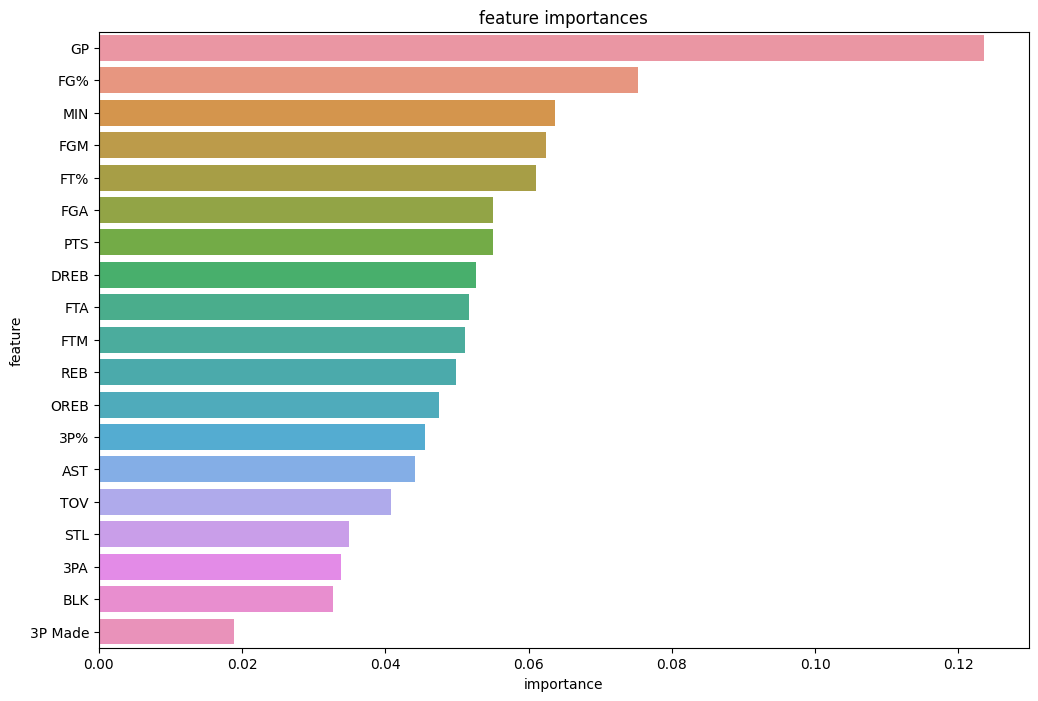

In [19]:
# let's see features importance of a randomforestclassifier
model = RandomForestClassifier()
model.fit(df_n_X_scaled, df_n_y)

importances = model.feature_importances_
feature_importance = pd.DataFrame({"feature": df_n_X.columns, 'importance':importances})
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

#visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('feature importances')
plt.show()

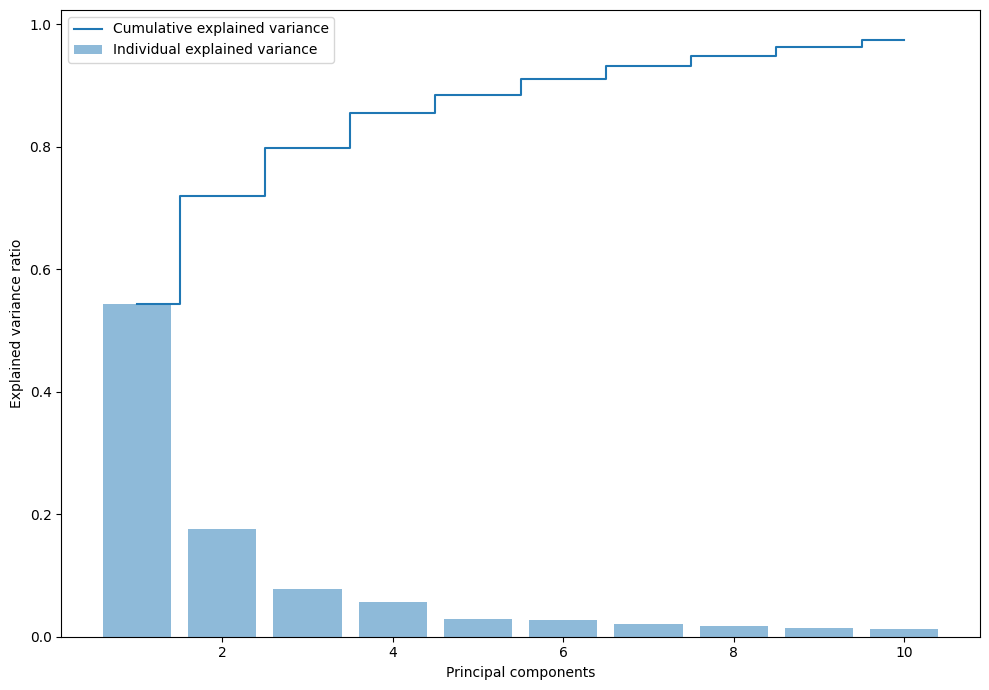

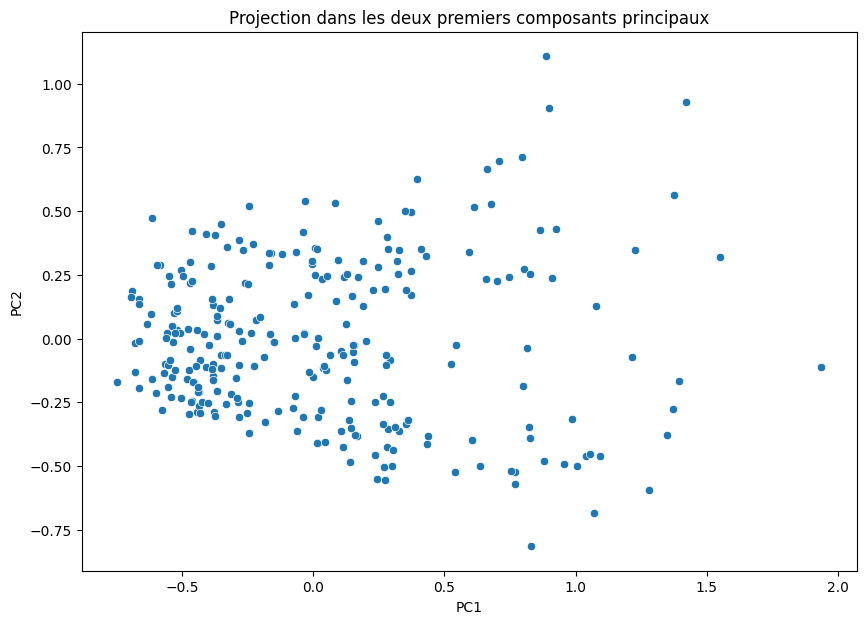

In [20]:
## visualize pca
from sklearn.decomposition import PCA

# initialization
pca = PCA(n_components=10) 

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

principalDf = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(10)])

#variance
plt.figure(figsize=(10,7))
plt.bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 11), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,7))
sns.scatterplot(x=principalDf['PC1'], y=principalDf['PC2'])
plt.title('Projection dans les deux premiers composants principaux')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [21]:
# testing grid search for svm
def f1_recall_weighted(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    return 2 * (recall * precision) / (recall + precision)
def grid_search_svm(X_train, X_test, y_train, y_test):
    param_grid = {
                    'C': [0.1, 1, 10, 100],  # Regularization parameter
                    'kernel': ['linear', 'rbf'],  # Kernel type
                    'gamma': [0.01, 0.1, 1, 'auto'],  # Kernel coefficient
                    'degree': [2, 3, 4],  # Degree of the polynomial kernel function
                }
    svm = SVC()
    # Perform Grid Search
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring=make_scorer(f1_recall_weighted))
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    recall = recall_score(y_test, y_pred)
    # print("Recall:", recall)
    return best_model

best_svm = grid_search_svm(X_train, X_test, y_train, y_test)
score_classifier(X,best_svm,labels)

Recall 0.8242704102149346
Precision 0.737621104771966
F1 score 0.7783979431367166
Confusion matrix
 [[265 146]
 [244 685]]


(0.8242704102149346,
 0.737621104771966,
 0.7783979431367166,
 SVC(C=1, degree=2, gamma=0.1))

In [22]:
def hand_features(data_df):

    # colomn selection from correlation matrix
    selected_columns = ['GP', 'MIN', 'PTS', 'FG%', 'FT%', 'REB', 'AST', 'STL', 'BLK', 'TOV']
    data_df = data_df[selected_columns]
    df = data_df.copy()

    # extract features
    df['TOTAL_PTS'] = df['GP'] * df["PTS"]
    df['EFFICIENCY'] = df['TOTAL_PTS'] / (df['MIN'] * df['GP'])

    # drop no longer needed colomns
    df.drop(columns=['GP', 'MIN', 'PTS'])
    

    df_vals = df.values
    for x in np.argwhere(np.isnan(df_vals)):
        df_vals[x]=0.0
    # normalize dataset
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_vals)

    return X_scaled

In [23]:
# Function to test multiple feature selection techniques and classifiers 
def test_feature_selection_and_classifiers(df):
    """
    Tests various feature selection methods and classifiers on the given dataset.

    Parameters:
    df (DataFrame): DataFrame containing the dataset with player statistics, names, and target labels.

    Returns:
    dict: A dictionary with the best models and their performance metrics for different investor types:
          - Cautious investors (best recall)
          - Selective investors (best precision)
          - Balanced investors (best f1 score)
    """

    # extract names, labels, features names and values
    names = df['Name'].values.tolist() # players names
    labels = df['TARGET_5Yrs'].values # labels
    paramset = df.drop(['TARGET_5Yrs','Name'],axis=1).columns.values
    df_vals = df.drop(['TARGET_5Yrs','Name'],axis=1).values

    # replacing Nan values (only present when no 3 points attempts have been performed by a player)
    for x in np.argwhere(np.isnan(df_vals)):
        df_vals[x]=0.0

    # normalize dataset
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df_vals)
    y = df['TARGET_5Yrs']

    

    # Define feature selection methods
    feature_selections = {
        'All_features': X_scaled,
        'hand_selected_feature': hand_features,
        'RFE_LogisticRegression': RFE(LogisticRegression(), n_features_to_select=10),
        'SelectKBest_Chi2': SelectKBest(chi2, k=10),
        'PCA': PCA(n_components=10),
    }

    # Define classifiers
    classifiers = {
        'LogisticRegression': LogisticRegression(random_state=SEED),
        'RandomForestClassifier': RandomForestClassifier(n_estimators=20, random_state=SEED),
        'sgd': SGDClassifier(random_state=SEED),
        'adaBoostClassifier': AdaBoostClassifier(base_estimator=SGDClassifier(), n_estimators=20, random_state=SEED, algorithm='SAMME'),
        'nb': GaussianNB(),
        'SVM': SVC(random_state=SEED),
        'lgb': LGBMClassifier(random_state=SEED),
        'xgb': XGBClassifier(random_state=SEED),
        'xgbrf': XGBRFClassifier(random_state=SEED)
    }

    # Variables to store the best model and its performance
    best_model_for_balanced_investors = None
    best_model_for_cautious_investors = None
    best_model_for_selective_investors = None

    best_score_recall = 0
    best_score_precision = 0
    best_score_f1 = 0

    best_name_recall = ""
    best_name_precision = ""
    best_name_f1 = ""

    selected_features = []
    selected_feature_mask = []

    # Test each combination of feature selection and classifier
    for fs_name, fs_method in feature_selections.items():
        if fs_name == 'All_features':
            X_selected = fs_method
            selected_features = paramset
        elif fs_name == 'PCA':
            X_selected = fs_method.fit_transform(X_scaled)
        elif fs_name == 'hand_selected_feature':
            X_selected = fs_method(df)
        elif fs_name == 'SelectKBest_Chi2':
            X_selected = fs_method.fit_transform(X_scaled, y)
            selected_feature_mask = fs_method.get_support()
            selected_features = paramset[selected_feature_mask]
            print("********************************* selected features : ", selected_features)
        else:
            X_selected = fs_method.fit_transform(X_scaled, y)
            selected_feature_mask = fs_method.support_
            selected_features = paramset[selected_feature_mask]
            print("********************************* selected features : ", selected_features)
        print("#################################   nb of features : ", X_selected.shape[1])
        
        

        for clf_name, clf in classifiers.items():
            print(f"Testing {fs_name} with {clf_name}")
            recall, precision, f1, clf = score_classifier(X_selected, clf, y)
            # Use wanted score as the primary metric to select the best model
            if recall > best_score_recall:
                best_score_recall = recall
                best_model_for_cautious_investors = clf
                best_name_recall = f"{fs_name} with {clf_name}"
            if precision > best_score_precision:
                best_score_precision = precision
                best_model_for_selective_investors = clf
                best_name_precision = f"{fs_name} with {clf_name}"
            if f1 > best_score_f1:
                best_score_f1 = f1
                best_model_for_balanced_investors = clf
                best_name_f1 = f"{fs_name} with {clf_name}"
                
    results = {
        "best_model_for_cautious_investors" : (best_model_for_cautious_investors, best_name_recall, best_score_recall, selected_features, selected_feature_mask),
        "best_model_for_selective_investors" : (best_model_for_selective_investors, best_name_precision, best_score_precision, selected_features, selected_feature_mask),
        "best_model_for_balanced_investors" : (best_model_for_balanced_investors, best_name_f1, best_score_f1, selected_features, selected_feature_mask),
    } 
    return results

# Load the data
df = pd.read_csv('data/nba_logreg.csv')

# Test feature selection and classifiers
results = test_feature_selection_and_classifiers(df)
results

#################################   nb of features :  19
Testing All_features with LogisticRegression
Recall 0.8351030883971994
Precision 0.736162879880994
F1 score 0.7823922801560981
Confusion matrix
 [[260 137]
 [249 694]]
Testing All_features with RandomForestClassifier
Recall 0.7649245484352432
Precision 0.7288516546382678
F1 score 0.746440194066399
Confusion matrix
 [[273 195]
 [236 636]]
Testing All_features with sgd
Recall 0.7674482606366663
Precision 0.7478503211941699
F1 score 0.7532908080821374
Confusion matrix
 [[287 194]
 [222 637]]
Testing All_features with adaBoostClassifier
Recall 0.6746064198780365
Precision 0.7829359724096566
F1 score 0.7247137609554907
Confusion matrix
 [[354 270]
 [155 561]]
Testing All_features with nb
Recall 0.5118239079434933
Precision 0.8142290469964394
F1 score 0.62704114678948
Confusion matrix
 [[410 406]
 [ 99 425]]
Testing All_features with SVM
Recall 0.82551959002102
Precision 0.7426951153127018
F1 score 0.7816718135989326
Confusion matrix
 

{'best_model_for_cautious_investors': (AdaBoostClassifier(algorithm='SAMME', base_estimator=SGDClassifier(),
                     n_estimators=20, random_state=2024),
  'RFE_LogisticRegression with adaBoostClassifier',
  0.8778704276856298,
  array(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB',
         'REB'], dtype=object),
  array([ True,  True,  True,  True,  True, False, False, False, False,
          True,  True, False,  True,  True,  True, False, False, False,
         False])),
 'best_model_for_selective_investors': (GaussianNB(),
  'RFE_LogisticRegression with nb',
  0.8229500397636901,
  array(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB',
         'REB'], dtype=object),
  array([ True,  True,  True,  True,  True, False, False, False, False,
          True,  True, False,  True,  True,  True, False, False, False,
         False])),
 'best_model_for_balanced_investors': (LogisticRegression(random_state=2024),
  'All_features with LogisticRegr

## Client requests

In [24]:
# save the best model
joblib.dump(results['best_model_for_cautious_investors'][0], 'app/best_model_for_cautious_investors_v0.pkl')

['app/best_model_for_cautious_investors_v0.pkl']

In [25]:
#selected features
selected_features_mask = results['best_model_for_cautious_investors'][-1]
results['best_model_for_cautious_investors'][-2]

array(['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB',
       'REB'], dtype=object)

In [26]:
def create_stats_dict(values, selected_features_mask):

    # selected required features
    values = values[selected_features_mask]
    # print(values)

    # Define the keys in the specified order
    keys = [
        "gp", "Min", "pts", "fgm", "fga", "ftm", "fta", "oreb", "dreb", "reb", 
    ]
    
    # Create a dictionary by zipping the keys with the corresponding values
    stats_dict = dict(zip(keys, values))
    
    return stats_dict

import json
def save_dict_to_json(dictionary, filename):
    # Save the dictionary to a JSON file
    with open(filename, 'w') as json_file:
        json.dump(dictionary, json_file, indent=4)

In [27]:
# create a single payer json
data_dict = create_stats_dict(X_test[1], selected_features_mask)
save_dict_to_json(data_dict, 'test_examples/test0.json')

In [28]:
#create a batch json
batch = 5
batch_list = []
for i,val in enumerate(X_test):
    if i<batch:
        val = val[selected_features_mask]
        batch_list.append(list(val))
batch_dict = {"batches":batch_list}
save_dict_to_json(batch_dict, 'test_examples/test1_batch.json')

In [29]:
# single player request
!curl -X POST "http://127.0.0.1:8000/predict?batch=false" -H "Content-Type: application/json" -d @test_examples/test0.json

{"Prediction":1.0}

In [30]:
# batched request
!curl -X POST "http://127.0.0.1:8000/predict?batch=true" -H "Content-Type: application/json" -d @test_examples/test1_batch.json

{"Prediction":[1.0,1.0,1.0,1.0,1.0]}